In [44]:
import os
import pandas as pd 

In [45]:
models = ['DMF', 'LightGCN', 'NGCF', 'DGCF', 'CKE', 'CFKG', 'KGNNLS']
splits = [2, 4, 6, 8, 10]

This function is useful to read emission data - since in this repo we are providing the files already process, we skip this.

In [46]:
import re

def process_emission_file(emission_file):

    with open(emission_file, 'r') as file:
        file_content = file.read()
        pattern = re.compile(r'EmissionsData\((.*?)\)', re.DOTALL)
        matches = re.findall(pattern, file_content)

        emission_list = []
        for content in matches:
            pairs = [pair.strip() for pair in content.split(',')]
            data_dict = dict(pair.split('=') for pair in pairs)

            for key, value in data_dict.items():
                try:
                    data_dict[key] = float(value)
                except ValueError:
                    pass  
            emission_list.append(data_dict)
        
        emission_df = pd.DataFrame(emission_list)
        return emission_df


If the aggregated data already exists, just load it. Otherwise, create it by reading recommendation files.

In [47]:
if os.path.exists('results_amazonbooks.tsv'):

    run_df = pd.read_csv('results_amazonbooks.tsv', sep='\t')

else:

    run_df = pd.DataFrame()

    for model in models:

        for split in splits:

            dataset = f'amazon_books/epo200_results/{model}/amazon_books_60core_split_{split}'

            if os.path.exists(dataset):
                output_files = os.listdir(dataset)

                if len(output_files) > 0:

                    em = [x for x in output_files if 'emissions' in x][0]
                    rb = [x for x in output_files if 'recbo' in x][0]

                    emission_file = f'{dataset}/{em}'
                    recbole_file = f'{dataset}/{rb}'

                    recbole_df = pd.read_csv(recbole_file, sep='\t')
                    emission_df = process_emission_file(emission_file)

                    split = str(int(emission_df['project_name'].values[0].split('_')[-1][0:-1])*10)+'%'
                    model_name = emission_df['project_name'].values[0].split('_')[0][1:]
                    
                    emission_df['model'] = model_name
                    emission_df['split'] = split

                    run_row = pd.merge(emission_df, recbole_df, left_index=True, right_index=True, how='inner')
                    run_df = pd.concat([run_df, run_row])


    run_df.to_csv('amazon_books_aggregated_results.tsv', sep='\t', index=False)

display(run_df.head(5))


,project_name,run_id,duration,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,gpu_energy,ram_energy,...,hit@10,map@10,precision@10,gauc,itemcoverage@10,averagepopularity@10,giniindex@10,shannonentropy@10,tailpercentage@10,global_emissions_kg
0,'BPR_amazon_books_60core_split_2','cd89b3e1-07a9-4d3f-8a78-de9d9f32bbad',324.279306,0.000010,42.5,35.825371,10.277164,0.003828,0.003419,0.000924,...,0.1191,0.0058,0.0142,0.8118,0.4914,20.4839,0.8336,0.0004,0.0033,3.881419
1,'BPR_amazon_books_60core_split_4','305f84b1-7498-4acb-8081-c4e8f0c772b1',440.091535,0.000010,42.5,30.206632,10.277164,0.005195,0.005155,0.001256,...,0.1982,0.0111,0.0251,0.8919,0.4718,39.9051,0.8478,0.0004,0.0008,5.512851
2,'BPR_amazon_books_60core_split_6','88002378-b337-464d-932d-6069e79f5c99',549.795342,0.000011,42.5,27.022245,10.277164,0.006490,0.006849,0.001569,...,0.2426,0.0153,0.0326,0.9152,0.4726,55.1154,0.8416,0.0004,0.0007,7.081148
3,'BPR_amazon_books_60core_split_8','6ca26e7e-df87-4bab-90bf-eb73be6b23cb',666.909300,0.000011,42.5,25.883306,10.277164,0.007873,0.008596,0.001900,...,0.2930,0.0200,0.0412,0.9283,0.4841,70.9476,0.8324,0.0004,0.0003,8.725195
4,'BPR_amazon_books_60core_split_10','84274085-c86d-4a27-a0ac-0c4c0a7131a5',776.567785,0.000011,42.5,30.474757,10.277164,0.009168,0.010289,0.002215,...,0.3214,0.0255,0.0483,0.9361,0.5023,82.7032,0.8189,0.0003,0.0003,10.294100


In [48]:
# run_df.columns
# y = run_df.drop(columns = ['timestamp', 'emissions', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'latitude', 'longitude', 'emissions_kg'])
# y.to_csv('results_amazonbooks.tsv', sep='\t', index=False)

Emissions from kilograms to grams

Then we compute the global emission to guarantee anonymous results (data in this repo has been already anonymized, so we skip this step)

In [50]:
# # from kg to g
# run_df['emissions_kg'] = run_df['emissions'] * 1000

# # 475 gCO2/kWh world average carbon intensity in 2019 (https://www.iea.org/reports/global-energy-co2-status-report-2019/emissions)
# run_df['global_emissions_kg'] = run_df['energy_consumed'] * 0.475 * 1000

### Plot emissions at the varying of the percentage of training data

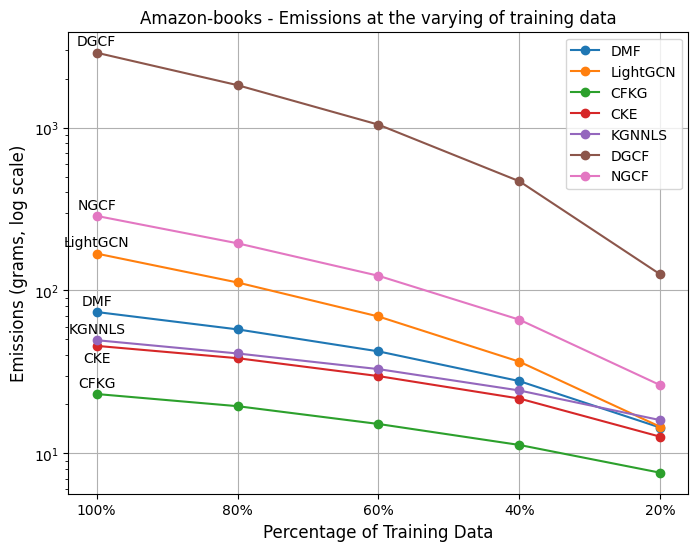

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

model_names = {}
for i, row in run_df.iterrows():
    if row['model'] not in model_names:
        model_names[row['model']] = {'split': [], 'emissions': []}
    model_names[row['model']]['split'].append(row['split'])
    model_names[row['model']]['emissions'].append(row['global_emissions_kg'])


for model_name, values in model_names.items():

    if model_name not in [  # poco sostenibili con migliori prestazioni
                            'LightGCN', 'NGCF', 'DGCF',
                        
                            # sostenibili con minori prestazioni
                           'CFKG', 'KGNNLS', 'CKE', 'DMF']:
                        
        continue


    
    plt.plot(values['split'], values['emissions'], label=model_name, marker='o')
    if not model_name == 'CKE':
        plt.annotate(model_name, (values['split'][-1], values['emissions'][-1]), textcoords="offset points", xytext=(0,5), ha='center')
    else:
        plt.annotate(model_name, (values['split'][-1], values['emissions'][-1]), textcoords="offset points", xytext=(0,-12), ha='center')
    
plt.yscale('log')
plt.xlabel('Percentage of Training Data', fontsize=12)
plt.ylabel('Emissions (grams, log scale)', fontsize=12)
plt.title('Amazon-books - Emissions at the varying of training data', fontsize=12)
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.savefig('graphs/amz_books_emissions')
plt.show()

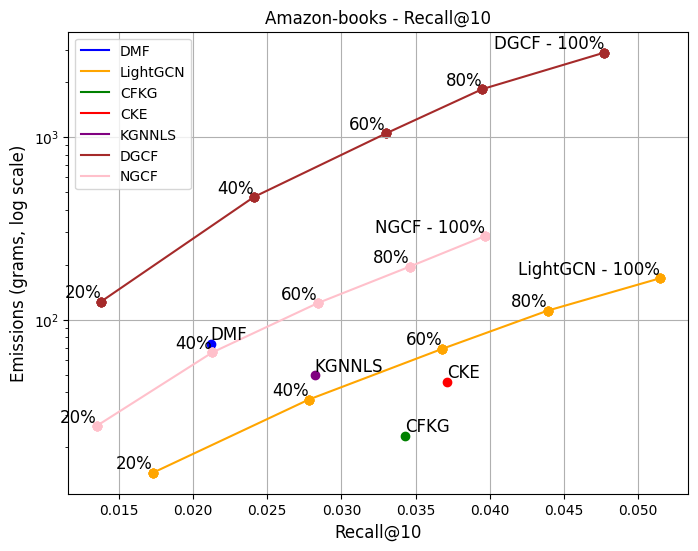

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

model_names = {}
for i, row in run_df.iterrows():
    if row['model'] in ['LightGCN', 'NGCF', 'DGCF']:
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'recall@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['recall@10'].append(row['recall@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])

    if row['model'] in ['CFKG', 'CKE', 
                        'DMF', 'KGNNLS'] and row['split'] == '100%':
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'recall@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['recall@10'].append(row['recall@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])


font_size = 12
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
color_i = 0


for model, values in model_names.items():
    color = colors[color_i]
    color_i += 1
    for i in range(len(values['emissions'])):
        x, y = values['emissions'][i], values['recall@10'][i]
        if model in ['LightGCN', 'NGCF', 'DGCF']:
            plt.scatter(values['recall@10'], values['emissions'], color=color)
            if values['split'][i] == '100%':
                plt.text(y, x, f'{model} - {values["split"][i]}', fontsize=font_size, ha='right', va='bottom')
            else:
                plt.text(y, x, str(values['split'][i]), fontsize=font_size, ha='right', va='bottom')
        if model in ['DMF', 'CKE', 'CFKG', 'KGNNLS']:
            plt.scatter(values['recall@10'], values['emissions'], color=color)
            plt.text(y, x, f'{model}', fontsize=font_size, ha='left', va='bottom')
    plt.plot(values['recall@10'], values['emissions'], label=model, color=color)

plt.yscale('log')  # Set logarithmic scale on y-axis
plt.ylabel('Emissions (grams, log scale)', fontsize=font_size,)
plt.xlabel('Recall@10', fontsize=font_size,)
plt.title('Amazon-books - Recall@10', fontsize=font_size,)
plt.legend()
plt.grid(True)
plt.savefig('graphs/amz_books_recall')
plt.show()


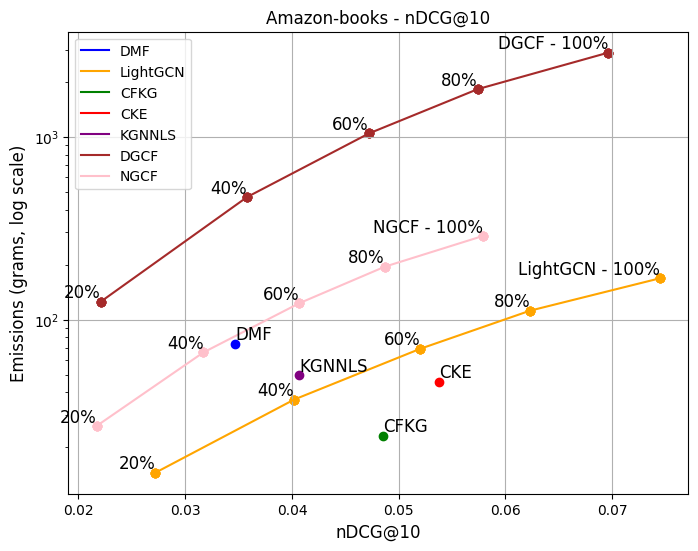

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

model_names = {}
for i, row in run_df.iterrows():
    if row['model'] in ['LightGCN', 'NGCF', 'DGCF',]:
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'ndcg@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['ndcg@10'].append(row['ndcg@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])

    if row['model'] in ['CFKG', 'CKE', 
                        'DMF', 'KGNNLS'] and row['split'] == '100%':
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'ndcg@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['ndcg@10'].append(row['ndcg@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])


font_size = 12
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
color_i = 0


for model, values in model_names.items():
    color = colors[color_i]
    color_i += 1
    for i in range(len(values['emissions'])):
        x, y = values['emissions'][i], values['ndcg@10'][i]
        if model in ['LightGCN', 'NGCF', 'DGCF', 'NAIS']:
            plt.scatter(values['ndcg@10'], values['emissions'], color=color)
            if values['split'][i] == '100%':
                plt.text(y, x, f'{model} - {values["split"][i]}', fontsize=font_size, ha='right', va='bottom')
            else:
                plt.text(y, x, str(values['split'][i]), fontsize=font_size, ha='right', va='bottom')
        if model in ['DMF', 'CKE', 'CFKG', 'KGNNLS']:
            plt.scatter(values['ndcg@10'], values['emissions'], color=color)
            plt.text(y, x, f'{model}', fontsize=font_size, ha='left', va='bottom')
    plt.plot(values['ndcg@10'], values['emissions'], label=model, color=color)

plt.yscale('log')  # Set logarithmic scale on y-axis
plt.ylabel('Emissions (grams, log scale)', fontsize=font_size,)
plt.xlabel('nDCG@10', fontsize=font_size,)
plt.title('Amazon-books - nDCG@10', fontsize=font_size,)
plt.legend()
plt.grid(True)
plt.savefig('graphs/amz_books_ndcg')
plt.show()

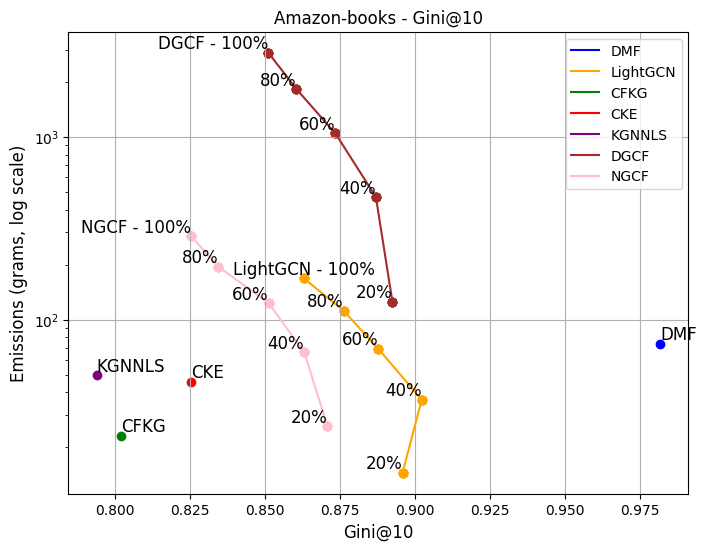

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

model_names = {}
for i, row in run_df.iterrows():
    if row['model'] in ['LightGCN', 'NGCF', 'DGCF']:
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'giniindex@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['giniindex@10'].append(row['giniindex@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])

    if row['model'] in ['CFKG', 'CKE', 'DMF', 'KGNNLS'] and row['split'] == '100%':
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'giniindex@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['giniindex@10'].append(row['giniindex@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])


font_size = 12
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
color_i = 0


for model, values in model_names.items():
    color = colors[color_i]
    color_i += 1
    for i in range(len(values['emissions'])):
        x, y = values['emissions'][i], values['giniindex@10'][i]
        if model in ['LightGCN', 'NGCF', 'DGCF', 'NAIS']:
            plt.scatter(values['giniindex@10'], values['emissions'], color=color)
            if values['split'][i] == '100%':
                if model == 'LightGCN':
                    plt.text(y, x, f'{model} - {values["split"][i]}', fontsize=font_size, ha='center', va='bottom')
                else:
                    plt.text(y, x, f'{model} - {values["split"][i]}', fontsize=font_size, ha='right', va='bottom')
            else:
                plt.text(y, x, str(values['split'][i]), fontsize=font_size, ha='right', va='bottom')

        if model in ['DMF', 'CKE', 'CFKG', 'KGNNLS']:
            plt.scatter(values['giniindex@10'], values['emissions'], color=color)
            plt.text(y, x, f'{model}', fontsize=font_size, ha='left', va='bottom')
    plt.plot(values['giniindex@10'], values['emissions'], label=model, color=color)

plt.yscale('log') 
plt.ylabel('Emissions (grams, log scale)', fontsize=font_size,)
plt.xlabel('Gini@10', fontsize=font_size,)
plt.title('Amazon-books - Gini@10', fontsize=font_size,)
plt.legend()
plt.grid(True)
plt.savefig('graphs/amz_books_gini')
plt.show()

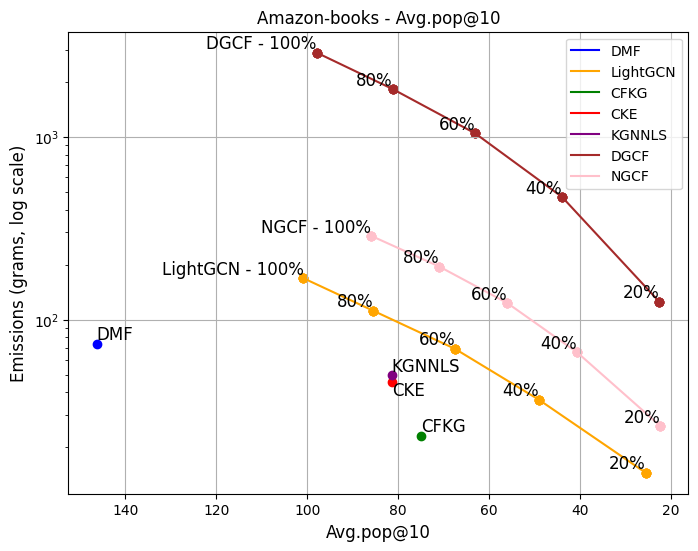

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

model_names = {}
for i, row in run_df.iterrows():
    if row['model'] in ['LightGCN', 'NGCF', 'DGCF']:
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'averagepopularity@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['averagepopularity@10'].append(row['averagepopularity@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])

    if row['model'] in ['CFKG', 'CKE', 'DMF', 'KGNNLS'] and row['split'] == '100%':
        if row['model'] not in model_names:
            model_names[row['model']] = {'split': [], 'emissions': [], 'averagepopularity@10': []}
        model_names[row['model']]['split'].append(row['split'])
        model_names[row['model']]['averagepopularity@10'].append(row['averagepopularity@10'])
        model_names[row['model']]['emissions'].append(row['global_emissions_kg'])


font_size = 12
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'black']
color_i = 0


for model, values in model_names.items():
    color = colors[color_i]
    color_i += 1
    for i in range(len(values['emissions'])):
        x, y = values['emissions'][i], values['averagepopularity@10'][i]
        if model in ['LightGCN', 'NGCF', 'DGCF', 'NAIS']:
            plt.scatter(values['averagepopularity@10'], values['emissions'], color=color)
            if values['split'][i] == '100%':
                plt.text(y, x, f'{model} - {values["split"][i]}', fontsize=font_size, ha='right', va='bottom')
            else:
                plt.text(y, x, str(values['split'][i]), fontsize=font_size, ha='right', va='bottom')
        if model in ['DMF', 'CFKG', 'KGNNLS']:
            plt.scatter(values['averagepopularity@10'], values['emissions'], color=color)
            plt.text(y, x, f'{model}', fontsize=font_size, ha='left', va='bottom')
        if model in ['CKE']:
            plt.scatter(values['averagepopularity@10'], values['emissions'], color=color)
            plt.text(y, x, f'{model}', fontsize=font_size, ha='left', va='top')
    plt.plot(values['averagepopularity@10'], values['emissions'], label=model, color=color)

plt.yscale('log') 
plt.ylabel('Emissions (grams, log scale)', fontsize=font_size,)
plt.xlabel('Avg.pop@10', fontsize=font_size,)
plt.title('Amazon-books - Avg.pop@10', fontsize=font_size,)
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.savefig('graphs/amz_books_pop')
plt.show()